In [35]:
import pandas as pd 
from spam_words import spam_words # local collection of words commonly found in spam, see spam_words.py
import re
import string
import nltk
from nltk.corpus import stopwords
import emoji
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statistics

In [36]:
stop_words = stopwords.words("english") # assign the Engolish stopwords to a variable
wn = nltk.WordNetLemmatizer() # collection of verbs, nouns, adjectives and adverbs - lemmitzer runs off this corpus
pd.set_option("display.max_colwidth",200) # set the widith of what appears for dataframes

In [37]:
file_path = r"SMSSpamCollection.tsv" # set the file path, just needs to be filename as the file is in the same folder
df = pd.read_csv(file_path,header=None,sep="\t") # load the dataet into a pandas df
df.columns = ["label","text"] # after df.head() we can set the column names
df.info() # Look for any missing values and make sure columns are same lenght

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5568 non-null   object
 1   text    5568 non-null   object
dtypes: object(2)
memory usage: 87.1+ KB


In [38]:
label_group = df["label"].value_counts()
print(label_group)

label
ham     4822
spam     746
Name: count, dtype: int64


In [54]:
def process_text(text:str)->list:
    '''Removes punctuation, performs tokenization, stop word removal, and lemmatization to a string and returns a list.'''
    text_no_punc = "".join([char.lower() for char in text if char not in string.punctuation]) # remove punc and lowercase the text
    tokens = re.split("\W+", text_no_punc) # tokenize the text
    tokens_no_stop = [word for word in tokens if word not in stop_words] # remove stop words
    lemmatized_tokens = [wn.lemmatize(word) for word in tokens_no_stop] # leematize the tokens
    return lemmatized_tokens

def analyze_text(text: str) -> dict:
    """Returns a strings length excluding spaces, the percentage of punctuation, 
       and the count of spam words in pd.Series"""
    length_no_spaces = len(text.replace(" ", "")) # Count length of string excluding whitespaces
    total_punc = sum(1 for char in text if char in string.punctuation) # Calculate the percent punctuation in string
    percent_punctuation = (total_punc / length_no_spaces) * 100 if length_no_spaces else 0 # Calculate the percentage punctuation
    spam_word_count = sum(word.lower() in spam_words for word in text.split()) # Count spam words

    return pd.Series([length_no_spaces,percent_punctuation,spam_word_count])

def count_emojis(text:str)->int:
    '''Counts how many emojis are in a string and returns int'''
    return emoji.emoji_count(text)

def train_rf(x_train,y_train,x_test,y_test,n_est,depth)->tuple:
    '''Function used for Grid-search that returns the precision, recall, f1score and support in a tuple'''
    rf = RandomForestClassifier(n_estimators=n_est,max_depth=depth,n_jobs=-1)
    rf_model = rf.fit(x_train, y_train)
    y_pred = rf_model.predict(x_test)
    accuracy = (y_pred == y_test).sum()/len(y_pred)
    model_score = score(y_test,y_pred,average='binary')
    return [accuracy,model_score]


In [40]:
df[["message_length", "percent_punc", "spam_word_count"]] = df["text"].apply(analyze_text) # Output the new features using analyze text func
df[["message_length", "spam_word_count"]] = df[["message_length", "spam_word_count"]].astype(int) # change columns from floating point to integers
df.describe() # inspect the properties of the new columns

,message_length,percent_punc,spam_word_count
count,5568.000000,5568.000000,5568.000000
mean,65.779095,7.098514,0.327227
std,48.820351,6.630682,0.840825
min,2.000000,0.000000,0.000000
25%,29.000000,3.278689,0.000000
50%,50.000000,5.454545,0.000000
75%,99.250000,9.090909,0.000000
max,740.000000,100.000000,6.000000


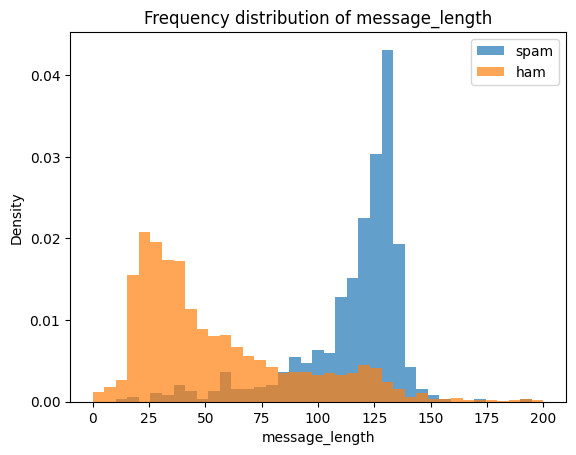

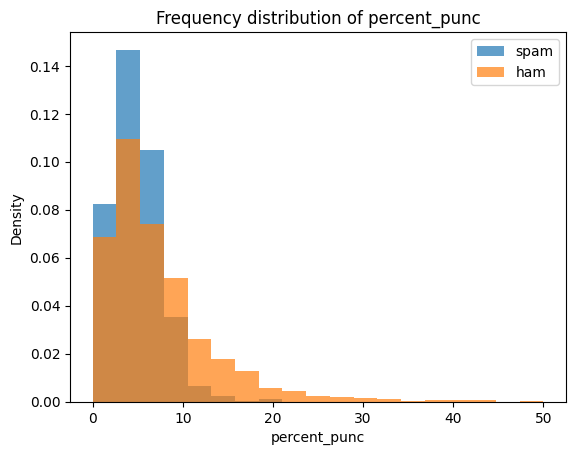

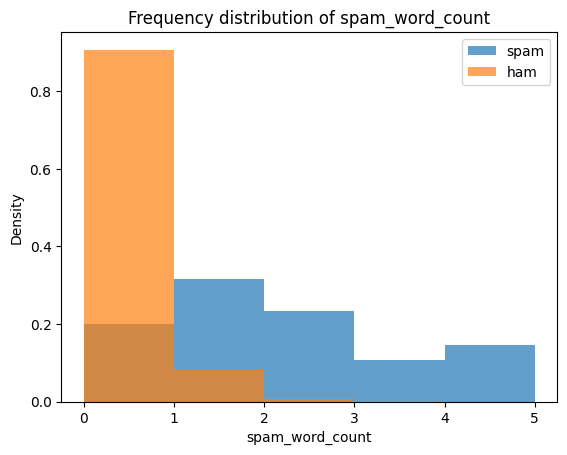

In [41]:
# Creat a frequency distribution to see how well each new feature correlates with the labels
column_names = ["message_length","percent_punc","spam_word_count"] # creat a list of column names for easy graph generation
bin_setting = [(0,200,40),(0,50,20),(0,5,6)] # create a list of tuples for setting bins

for i in range(len(column_names)):
    plt.hist(df[df["label"] == 'spam'][column_names[i]], bins=np.linspace(*bin_setting[i]), density=True, label='spam', alpha=0.7)
    plt.hist(df[df["label"] == 'ham'][column_names[i]], bins=np.linspace(*bin_setting[i]), density=True, label='ham', alpha=0.7)
    plt.xlabel(column_names[i])
    plt.ylabel('Density')
    plt.title(f"Frequency distribution of {column_names[i]}")
    plt.legend()
    plt.show()

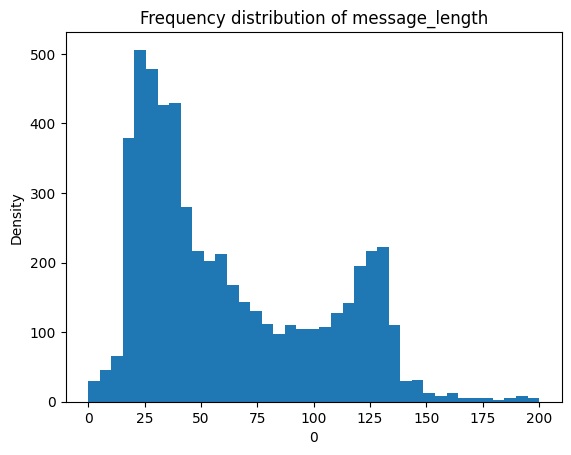

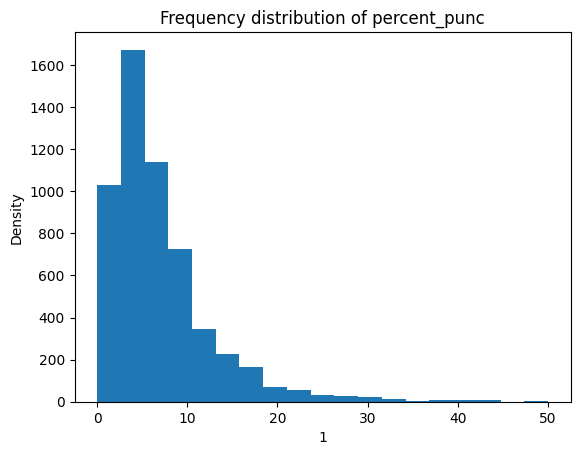

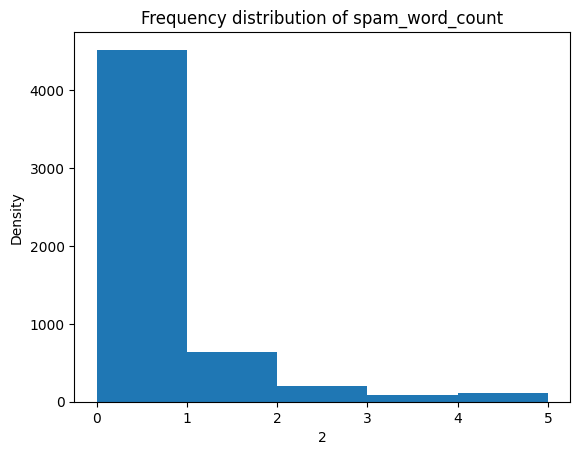

In [42]:
# Assess whether any of the features are good candidates for a data transformation
for i in range(len(column_names)):
    plt.hist(df[column_names[i]],bins=np.linspace(*bin_setting[i]),align="mid")
    plt.title(f"Frequency distribution of {column_names[i]}")
    plt.xlabel(i)
    plt.ylabel("Density")
    plt.show()


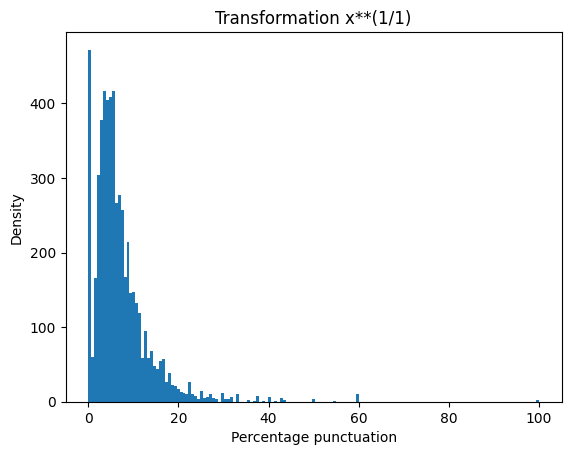

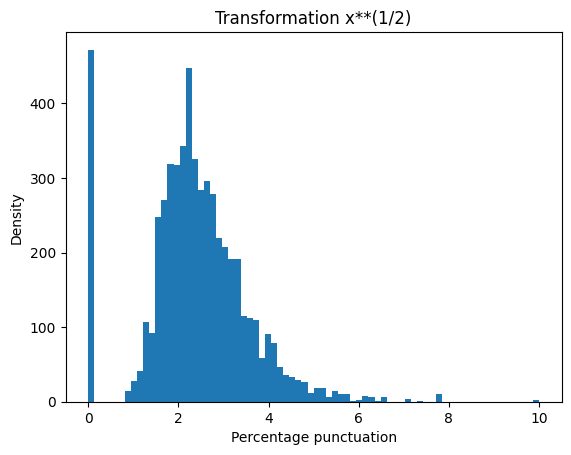

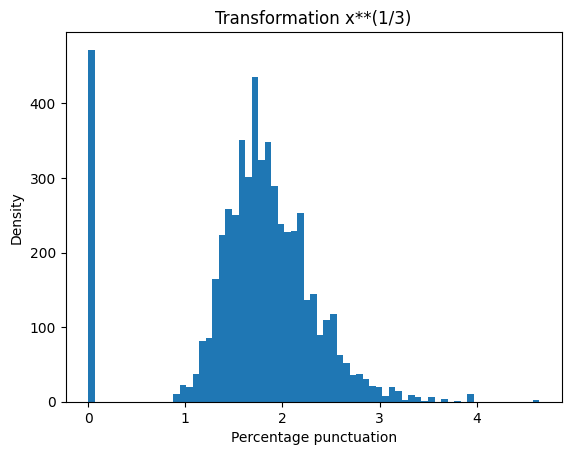

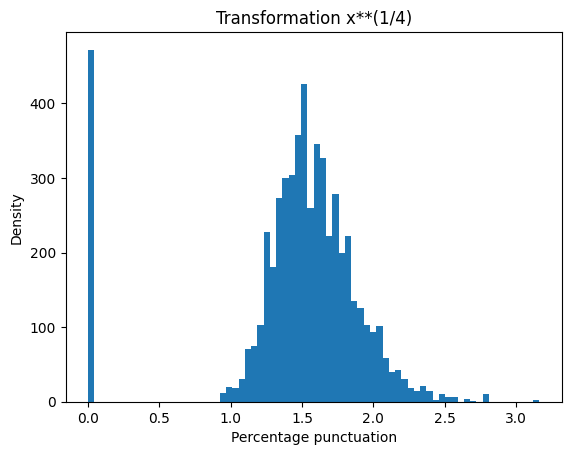

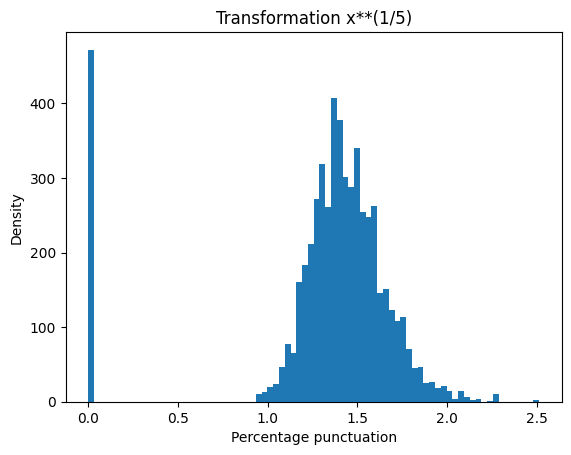

In [43]:
# Try a series of box-cox transformations on the percentage punc column
for i in range(1,6):
    plt.hist(df["percent_punc"].apply(lambda x: x**(1/i)), bins="auto")
    plt.title(f"Transformation x**(1/{i})")
    plt.ylabel("Density")
    plt.xlabel("Percentage punctuation")
    plt.show()

df["percent_punc"] = df["percent_punc"].apply(lambda x: x**(1/4)) # found the most suitable transformation, now apply it to the column


In [44]:
df["label"] = df["label"].replace({"spam": 1, "ham": 0}) # make labels binary
tfid_vect = TfidfVectorizer(analyzer=process_text)
X_tfidf = tfid_vect.fit_transform(df["text"])# create a sparse matrix
df_X_tfidf = pd.DataFrame(X_tfidf.toarray())
df_X_tfidf.columns = tfid_vect.get_feature_names_out()

X_features = pd.concat([df["message_length"],df["percent_punc"],df["spam_word_count"],df_X_tfidf], axis= 1) # Combine TF-IDF features with engineered features for modeling
X_features.columns.astype(str)
X_features.head()

,message_length,percent_punc,spam_word_count,,0,008704050406,0089my,0121,01223585236,01223585334,...,zindgi,zoe,zogtorius,zoom,zouk,zyada,é,ü,üll,〨ud
0,160,1.257433,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,1.471415,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,1.421374,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,1.340169,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,1.634813,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
x_train, x_test, y_train, y_test = train_test_split(X_features,df["label"],test_size=0.2)

rf = RandomForestClassifier(n_estimators=50,max_depth=20,n_jobs=-1)
rf_model = rf.fit(x_train,y_train)
sorted(zip(rf_model.feature_importances_,x_train.columns),reverse=True)[:10] # see what features are the most important

[(0.06844859205522834, 'message_length'),
 (0.059366675750479415, 'spam_word_count'),
 (0.034341782312757654, 'call'),
 (0.030455715780845848, 'mobile'),
 (0.029558311724279904, 'free'),
 (0.02295794832799489, 'claim'),
 (0.02054791216113851, 'txt'),
 (0.015485017859044875, 'text'),
 (0.014799427664131193, 'reply'),
 (0.014583526003119997, 'service')]

In [46]:
rf = RandomForestClassifier(n_estimators=50,max_depth=20,n_jobs=-1)
rf_model = rf.fit(x_train,y_train)
print(sorted(zip(rf_model.feature_importances_,x_train.columns),reverse=True)[:10]) # see what features are the most important
y_pred =  rf_model.predict(x_test)
# model_score = score(y_test,y_pred,average="binary")
# accuracy = (y_pred == y_test).sum()/len(y_pred)

[(0.09509757896002652, 'spam_word_count'), (0.0533676363973911, 'message_length'), (0.03302095135597576, 'claim'), (0.03187215450484944, 'txt'), (0.03039588114865313, 'mobile'), (0.0253604636925832, 'free'), (0.01853859889664486, 'call'), (0.017305991055371797, 'service'), (0.016861023027446558, 'reply'), (0.015679435827884478, '500')]


In [ ]:
# accuracy = (y_pred == y_test).sum()/len(y_pred)

# print(f"The models Precision is {model_score[0]*100}%")
# print(f"The models Recall is {model_score[1]*100:.2f}%")
# print(f"The models Accuracy is {accuracy*100:.2f}%")
# print(f"The models fscore is {model_score[2]*100:.2f}%")

# Percesion is great, accuracy is good, recall needs work i.e of 746 spam emails 237 are still getting through

In [59]:
# Use grid search to optimise the parameters and see if we can achieve a better accuracy and recall score
counter = 0
new_dict = {}
for n_est in range(10,110,10):
    for depth in range(10,40,10):
        model_score = train_rf(x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,n_est=n_est,depth=depth)
        counter += 1 
        new_dict[counter] = [model_score[0],model_score[1][1]]

In [63]:
for key,values in new_dict.items():
    print(f"Iteration {key}, Accuracy score: {values[0]*100:.3f}%, Recall score: {values[1]*100:.3f}%")

# Iteration 6 provided the best accuracy and recall, but there is still room for some improvement by automatin the grid search process

Iteration 1, Accuracy score: 92.370%, Recall score: 39.716%
Iteration 2, Accuracy score: 95.063%, Recall score: 61.702%
Iteration 3, Accuracy score: 96.679%, Recall score: 73.759%
Iteration 4, Accuracy score: 91.562%, Recall score: 33.333%
Iteration 5, Accuracy score: 95.512%, Recall score: 64.539%
Iteration 6, Accuracy score: 97.038%, Recall score: 76.596%
Iteration 7, Accuracy score: 91.293%, Recall score: 31.206%
Iteration 8, Accuracy score: 94.883%, Recall score: 59.574%
Iteration 9, Accuracy score: 96.409%, Recall score: 71.631%
Iteration 10, Accuracy score: 91.472%, Recall score: 32.624%
Iteration 11, Accuracy score: 95.601%, Recall score: 65.248%
Iteration 12, Accuracy score: 96.589%, Recall score: 73.050%
Iteration 13, Accuracy score: 91.113%, Recall score: 29.787%
Iteration 14, Accuracy score: 94.883%, Recall score: 59.574%
Iteration 15, Accuracy score: 96.320%, Recall score: 70.922%
Iteration 16, Accuracy score: 92.011%, Recall score: 36.879%
Iteration 17, Accuracy score: 95.